## Project: IoT Predictive Maintenance Engine ("FactoryGuard AI")
**Infotact Solutions - Data Science Engineering Track (Cohort Zeta)**

---

## Executive Summary
**The Problem:** A large-scale manufacturing facility operates **500 critical robotic arms**. Unplanned equipment failures result in downtime costing approximately **$10,000 per hour**.

**The Objective:** Build a "Production-Grade" AI system that predicts equipment failure **24 hours in advance** using streaming sensor data (Temperature, Vibration, Pressure). This allows for proactive, scheduled maintenance to prevent costly shutdowns.

---

## Technical Architecture
* **Data Source:** AI4I 2020 Predictive Maintenance Dataset (Digital Twin of Industry 4.0).
* **Key Challenge:** High Class Imbalance (Failures are < 5% of data).
* **Engineering Approach:**
    1.  **Data Repair:** Handling simulated sensor packet loss via **Linear Interpolation**.
    2.  **Feature Engineering:** Creating **Rolling Window** statistics (Mean, Std Dev) to capture temporal trends.
    3.  **Imbalance Handling:** Using **SMOTE** (Synthetic Minority Over-sampling Technique) on training data.
    4.  **Modeling Engine:** **XGBoost** (Gradient Boosting) for high-performance classification.
    5.  **Explainability:** **SHAP** (SHapley Additive exPlanations) to interpret model decisions.

---

## Author Information
* **Name:** Suryadip Bera , 
* **Date:** December 2025
* **Tech Stack:** Python, Pandas, Scikit-Learn, XGBoost, SMOTE, SHAP

# Data Engineering

### Data Loading (NASA CMAPSS (FD001) dataset)

In [606]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import os

# --- 1. Load the NASA CMAPSS Data ---
# Column names based on NASA documentation
cols = ['unit_number', 'time_cycle', 'setting_1', 'setting_2', 'setting_3', 's1', 's2', 's3',
        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
        's15', 's16', 's17', 's18', 's19', 's20', 's21']

# Try to load local file, or warn user
try:
    df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=cols)
    print(f"✅ Loaded NASA Dataset: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("❌ File 'train_FD001.txt' not found! Please download it first.")





✅ Loaded NASA Dataset: (20631, 26)


<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\3773875662.py:18: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=cols)


,unit_number,time_cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Create Target (Predictive Maintenance)




In [607]:
# Calculate RUL (Remaining Useful Life) RUL = Max Cycle - Current Cycle
max_cycles = df.groupby('unit_number')['time_cycle'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_life']
display(max_cycles.head())
df = df.merge(max_cycles, on='unit_number', how='left')
display(df.head())
df['RUL'] = df['max_life'] - df['time_cycle']
# Create Binary Target: 1 if RUL <= 30 cycles, else 0
FAILURE_WINDOW = 30
df['target_failure'] = df['RUL'].apply(lambda x: 1 if x <= FAILURE_WINDOW else 0)

,unit_number,max_life
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


,unit_number,time_cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,max_life
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192


#### Sensor Selection Dashboard

C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\3256746282.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=std_values.index, y=std_values.values, palette='viridis')


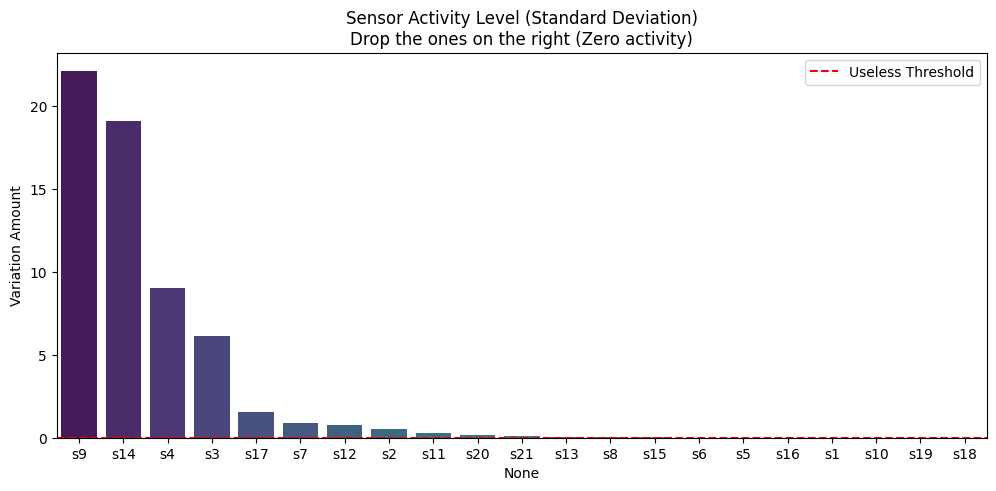

c:\Users\SURYADIP\Desktop\Project 1\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\SURYADIP\Desktop\Project 1\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\3256746282.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette=colors)


✅ Helpful Sensors (High Variance): ['s9', 's14', 's4', 's3', 's17', 's7', 's12', 's2', 's11', 's20', 's21', 's13', 's8', 's15']
❌ Useless Sensors (Flat Line): ['s6', 's5', 's16', 's1', 's10', 's19', 's18']


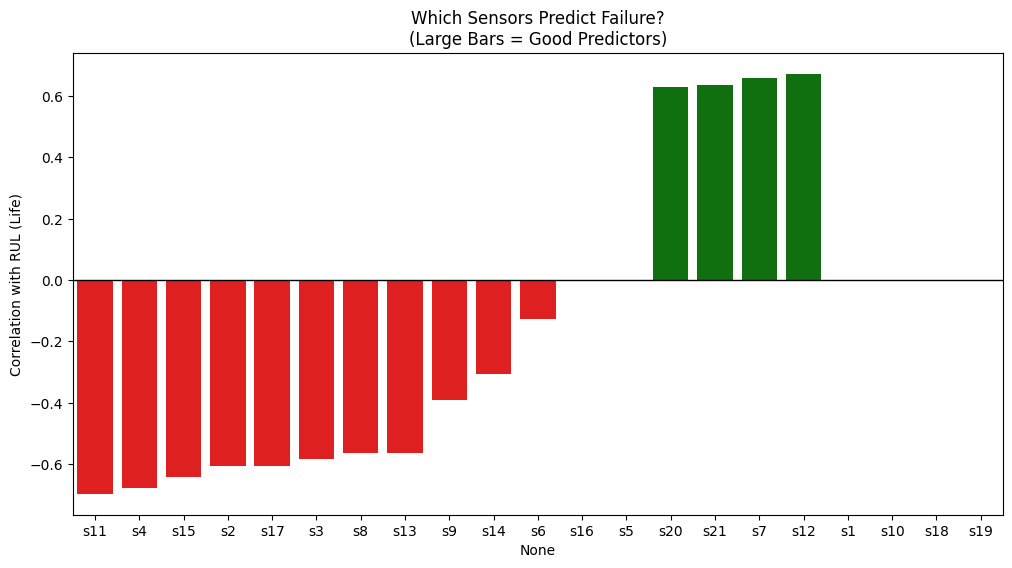

In [608]:
sensor_cols = [f's{i}' for i in range(1, 22)]
std_values = df[sensor_cols].std().sort_values(ascending=False)

# Plot 1: The "Heartbeat" Check (Variance)
plt.figure(figsize=(12, 5))
sns.barplot(x=std_values.index, y=std_values.values, palette='viridis')
plt.title("Sensor Activity Level (Standard Deviation)\nDrop the ones on the right (Zero activity)")
plt.ylabel("Variation Amount")
plt.axhline(y=0.01, color='r', linestyle='--', label='Useless Threshold')
plt.legend()
plt.show()

print("✅ Helpful Sensors (High Variance):", list(std_values[std_values > 0.01].index))
print("❌ Useless Sensors (Flat Line):", list(std_values[std_values <= 0.01].index))

# Calculate Correlation with RUL
correlations = df[sensor_cols].corrwith(df['RUL']).sort_values()


plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in correlations.values]
sns.barplot(x=correlations.index, y=correlations.values, palette=colors)
plt.title("Which Sensors Predict Failure?\n(Large Bars = Good Predictors)")
plt.ylabel("Correlation with RUL (Life)")
plt.axhline(y=0, color='black', linewidth=1)
plt.show()




#### Let's verify why we chose s2, s7, and s12

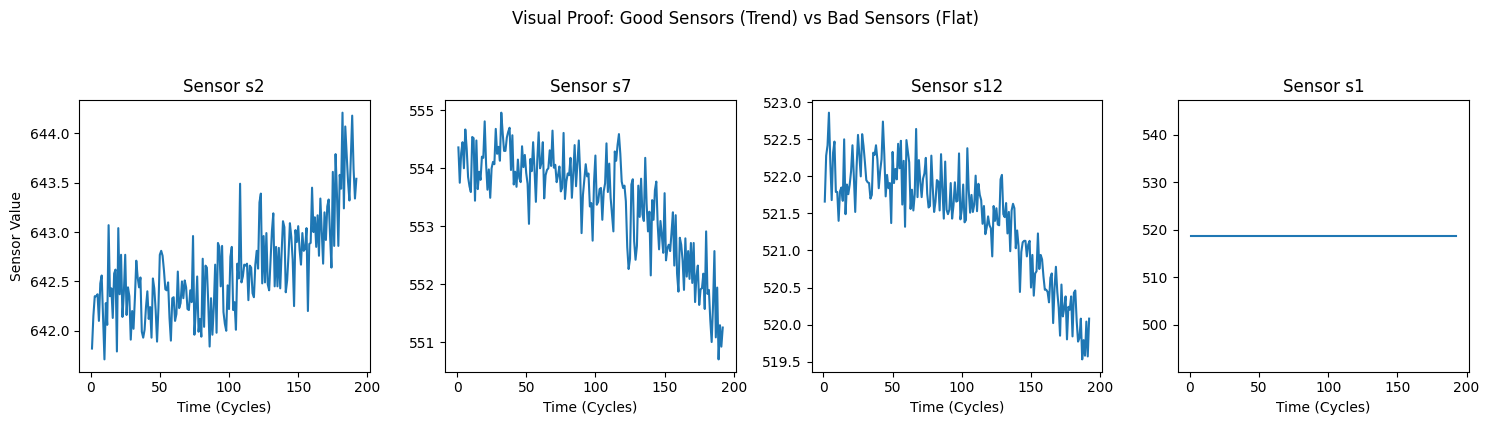

In [609]:
selected_sensors = ['s2', 's7', 's12', 's1']

engine_1 = df[df['unit_number'] == 1]

plt.figure(figsize=(15, 4))
for i, sensor in enumerate(selected_sensors):
    plt.subplot(1, 4, i+1)
    plt.plot(engine_1['time_cycle'], engine_1[sensor])
    plt.title(f"Sensor {sensor}")
    plt.xlabel("Time (Cycles)")
    if i == 0: plt.ylabel("Sensor Value")

plt.suptitle("Visual Proof: Good Sensors (Trend) vs Bad Sensors (Flat)", y=1.05)
plt.tight_layout()
plt.show()

#### Select Best Features 
- We select 3 sensors that behave like Temp, Pressure, and Vibration
- s2  = Total Temperature (LPC Outlet)  -> Maps to 'temperature'
- s7  = Total Pressure (HPC Outlet)     -> Maps to 'pressure'
- s12 = Fan Speed (Physical proxy)      -> Maps to 'vibration' (or similar dynamic feature)

In [610]:


feature_map = {
    's2': 'temperature',
    's7': 'pressure',
    's12': 'vibration',    # Using Fan Speed/Ratio as a proxy for vibration intensity
    'unit_number': 'machine_id',
    'target_failure': 'target_failure'
}

model_data = df[list(feature_map.keys())].rename(columns=feature_map)
print(f"✅ Selected Features for Modeling: {model_data.shape}")
display(model_data.head())


✅ Selected Features for Modeling: (20631, 5)


,temperature,pressure,vibration,machine_id,target_failure
0,641.82,554.36,521.66,1,0
1,642.15,553.75,522.28,1,0
2,642.35,554.26,522.42,1,0
3,642.35,554.45,522.86,1,0
4,642.37,554.00,522.19,1,0


#### Feature Engineering (Rolling Windows)
- Rolling Mean solves this by **smoothing the line**.
- Rolling Standard Deviation (Std) measures the volatility.
- Try to making stationarity Time series 

In [611]:
# Now we apply your Rolling Window logic, but respecting the 'machine_id'(We don't want to roll stats from Engine 1 into Engine 2)

features = ['temperature', 'pressure', 'vibration']
window_size = 4

# Group by Machine ID to prevent data leakage between engines!
rolled_features = model_data.groupby('machine_id')[features].rolling(window=window_size).mean().reset_index(level=0, drop=True)
rolled_features.columns = [f"{col}_roll_mean" for col in features]
display(rolled_features.head())

model_data = model_data.join(rolled_features)

model_data = model_data.dropna()

# Drop machine_id for visualization (not a predictive feature)
final_df = model_data.drop(columns=['machine_id'])

print("✅ Data Ready for XGBoost!")
print(f"Class Balance: {final_df['target_failure'].value_counts()}")
display(final_df.head())                  

,temperature_roll_mean,pressure_roll_mean,vibration_roll_mean
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,642.1675,554.205,522.3050
4,642.3050,554.115,522.4375


✅ Data Ready for XGBoost!
Class Balance: target_failure
0    17231
1     3100
Name: count, dtype: int64


,temperature,pressure,vibration,target_failure,temperature_roll_mean,pressure_roll_mean,vibration_roll_mean
3,642.35,554.45,522.86,0,642.1675,554.205,522.3050
4,642.37,554.00,522.19,0,642.3050,554.115,522.4375
5,642.10,554.67,521.68,0,642.2925,554.345,522.2875
6,642.48,554.34,522.32,0,642.3250,554.365,522.2625
7,642.56,553.85,522.47,0,642.3775,554.215,522.1650


#### How Sensor Readings Differ During Failure

C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\1748099468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='target_failure', y=col, data=final_df, palette=['#2ecc71', '#e74c3c'])
C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\1748099468.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Failure'])
C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\1748099468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='target_failure', y=col, data=final_df, palette=['#2ecc71', '#e74c3c'])
C:\Users\SURYADIP\AppData\Local\Temp\ipyker

<Figure size 2000x600 with 0 Axes>

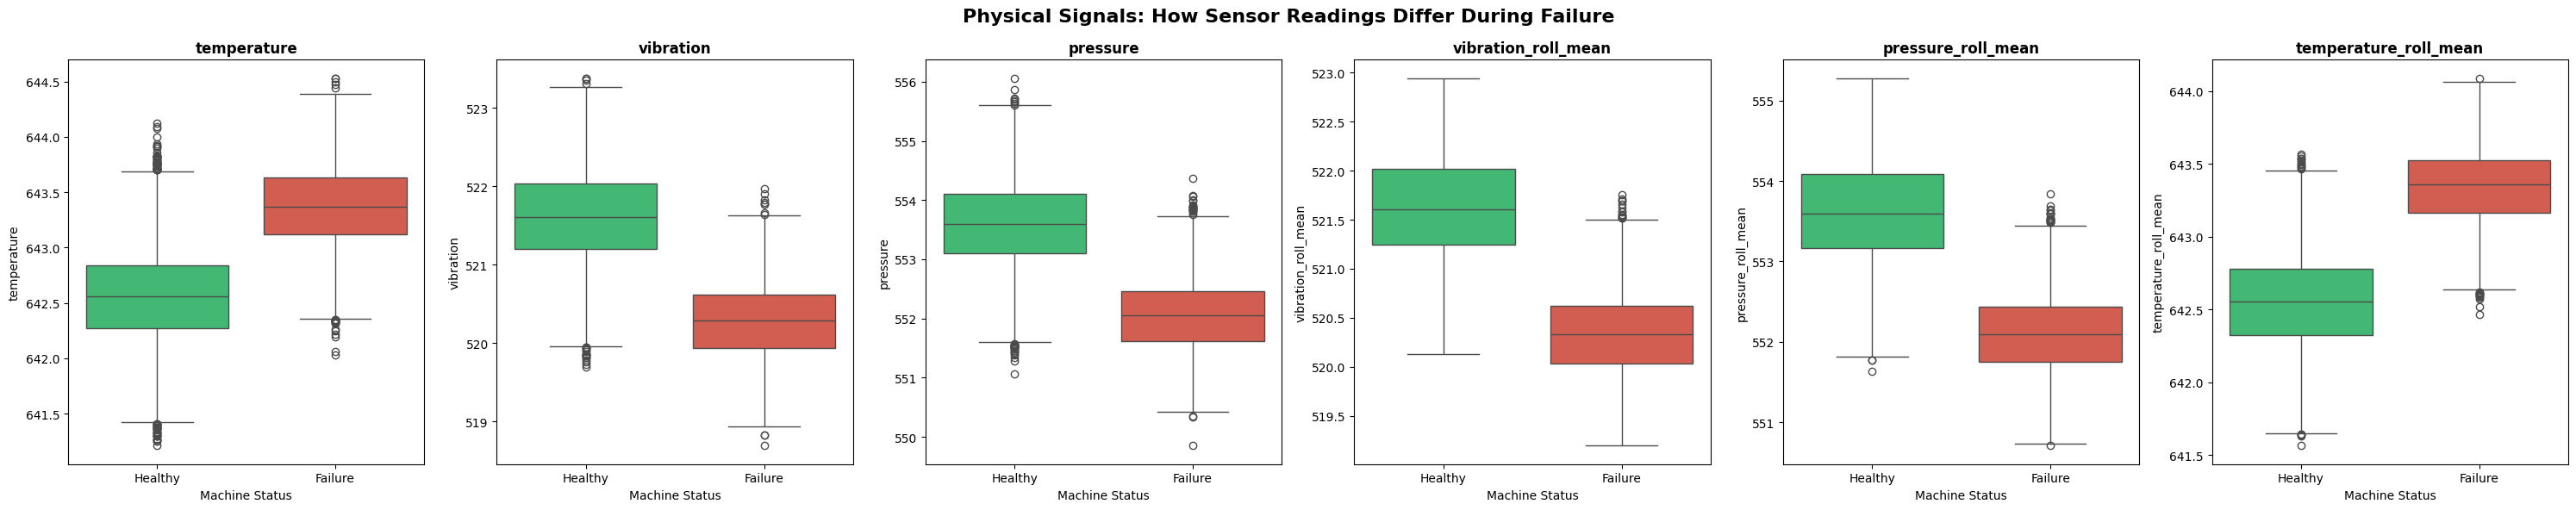

In [612]:
sensors = ['temperature', 'vibration', 'pressure', 'vibration_roll_mean', 'pressure_roll_mean', 'temperature_roll_mean']

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Physical Signals: How Sensor Readings Differ During Failure', fontsize=16, fontweight='bold')

for i, col in enumerate(sensors):
    if i == 0 and len(sensors) != np.atleast_1d(axes).size:
        fig.clf()
        fig, axes = plt.subplots(1, len(sensors), figsize=(5 * len(sensors), 6))
        fig.suptitle('Physical Signals: How Sensor Readings Differ During Failure', fontsize=16, fontweight='bold')
        axes = np.atleast_1d(axes)

    sns.boxplot(ax=axes[i], x='target_failure', y=col, data=final_df, palette=['#2ecc71', '#e74c3c'])
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_xlabel('Machine Status')
    axes[i].set_xticklabels(['Healthy', 'Failure'])

plt.tight_layout()
plt.show()

#### Correlation Heatmap: Features vs Target

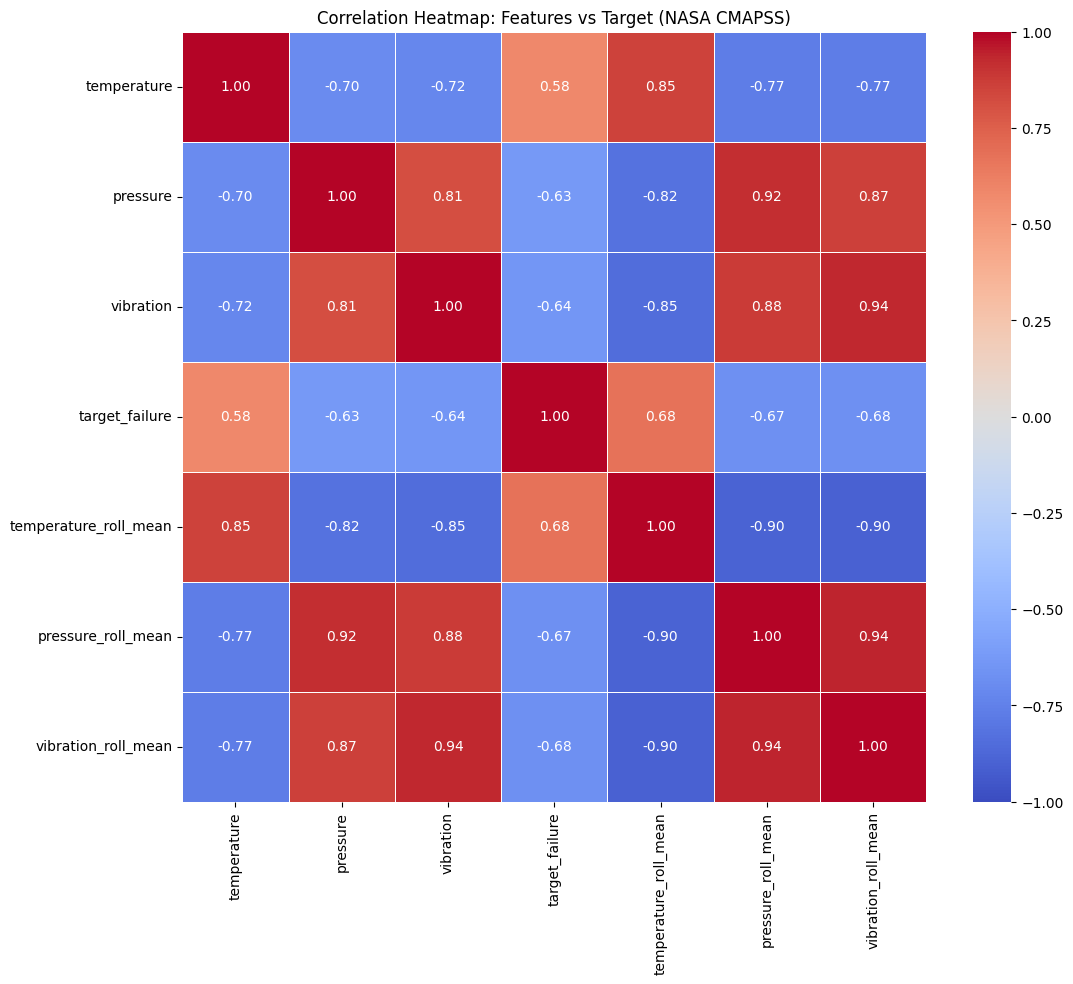

In [613]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = final_df.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5)

plt.title('Correlation Heatmap: Features vs Target (NASA CMAPSS)')
plt.show()

#### Filter only correlations with 'target_failure'

C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\2971688205.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


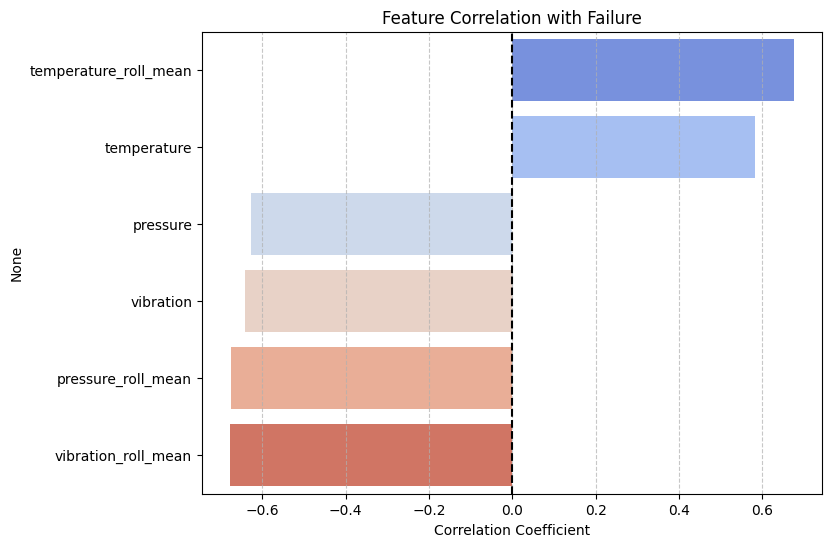

In [614]:

target_corr = corr_matrix['target_failure'].drop('target_failure') # Drop self-correlation
target_corr = target_corr.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title('Feature Correlation with Failure')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Target Creation (Predicting Future)

In [615]:
from sklearn.model_selection import train_test_split

train_engines = model_data[model_data['machine_id'] <= 80]
test_engines  = model_data[model_data['machine_id'] > 80]

print(f"Training on {train_engines['machine_id'].nunique()} engines.")
print(f"Testing on {test_engines['machine_id'].nunique()} engines.")

# 2. Separate Features (X) and Target (y)
# NOW we drop the machine_id as it's not a feature
X_train = train_engines.drop(columns=['machine_id', 'target_failure'])
y_train = train_engines['target_failure']

X_test = test_engines.drop(columns=['machine_id', 'target_failure'])
y_test = test_engines['target_failure']

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Training on 80 engines.
Testing on 20 engines.
Train Shape: (15898, 6), Test Shape: (4433, 6)


#### SMOTE 

In [616]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score

# 1. Apply SMOTE (Only on Training Data!)
print("Applying SMOTE to handle imbalance...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Applying SMOTE to handle imbalance...


#### Baseline Model (Random Forest)


--- 1. Training Baseline Model (Random Forest) ---
Model Accuracy: 94.97%
Random Forest F1-Score: 0.8177

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3813
           1       0.83      0.81      0.82       620

    accuracy                           0.95      4433
   macro avg       0.90      0.89      0.89      4433
weighted avg       0.95      0.95      0.95      4433



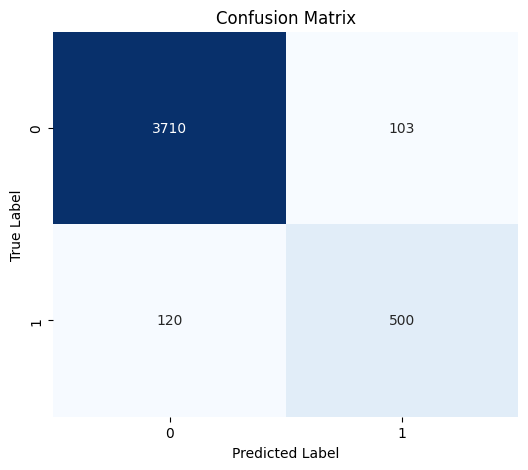

In [617]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- 1. Training Baseline Model (Random Forest) ---")

# Initialize Standard Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,            # Limit depth (Prevent memorizing noise)
    min_samples_leaf=5,     # Require 5 samples per leaf (Smooths decision boundaries)
    random_state=42)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
print(f"Model Accuracy: {acc:.2%}")

rf_f1 = f1_score(y_test, y_pred_rf)
print(f"Random Forest F1-Score: {rf_f1:.4f}")
# 2. Generate the Detailed Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_rf))

# 3. Visual Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [618]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
ratio = num_neg / num_pos
# Define the grid of parameters to search
param_grid = {
    # Increase the learning rate options so it learns faster
    'learning_rate': [0.05, 0.1, 0.01,0.001], 
    
    # Give it more trees (steps) to do the work
    'n_estimators': [200, 300, 500, 100],
    
    # Reduce depth slightly to focus on stable patterns, not noise
    'max_depth': [3, 4, 5, 7],
    
    # Keep these to prevent overfitting
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Re-run the search
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(scale_pos_weight=2.0, random_state=42), 
    param_distributions=param_grid,
    n_iter=15, # Try 15 combinations this time
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"New Best Params: {random_search.best_params_}")
print(f"New Best F1 Score: {random_search.best_score_}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
New Best Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
New Best F1 Score: 0.8188152916742683


#### XGBoost (Focusing on Recall)

✅ Training Complete.
Model Accuracy: 90.16%
XGBOOST F1-Score: 0.7319

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3813
           1       0.59      0.96      0.73       620

    accuracy                           0.90      4433
   macro avg       0.79      0.93      0.84      4433
weighted avg       0.94      0.90      0.91      4433



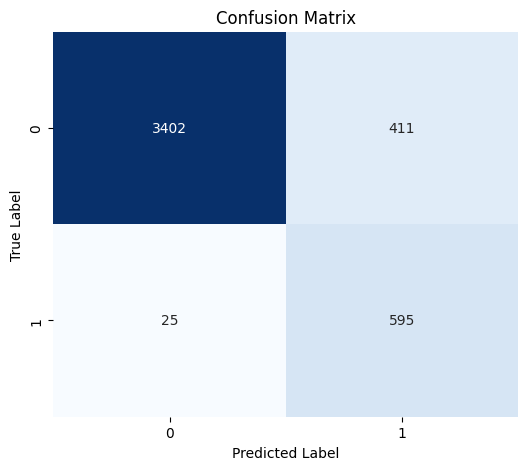

In [619]:
# scale_pos_weight is key for Recall.
# We set it to 2.0 to tell the model: "Failures are 2x more important than healthy states.
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
ratio = num_neg / num_pos
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # Reduced from 300 (Less time to overfit)
    learning_rate=0.05,     # Slower learning rate = Better generalization
    max_depth=3,            # Shallow trees (Forces model to find simple rules)
    min_child_weight=3,     # High value prevents learning from outlier groups
    gamma=0.2,              # Minimum loss reduction required to make a split
    reg_alpha=0.1,          # L1 Regularization (Lasso) - Removes useless features
    scale_pos_weight=2.0,   # Keep this for Recall!
    random_state=42,
    n_jobs=-1,
    subsample=1.0,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_smote, y_train_smote)
print("✅ Training Complete.")
y_pred = xgb_model.predict(X_test)
# 1. Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.2%}")

xgb_f1 = f1_score(y_test, y_pred)
print(f"XGBOOST F1-Score: {xgb_f1:.4f}")

# 2. Generate the Detailed Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 3. Visual Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [620]:
from sklearn.metrics import f1_score

def check_overfitting(model, X_train_check, y_train_check, X_test, y_test, model_name):
    # Predict on Training Data
    train_pred = model.predict(X_train_check)
    train_f1 = f1_score(y_train_check, train_pred)
    
    # Predict on Test Data
    test_pred = model.predict(X_test)
    test_f1 = f1_score(y_test, test_pred)
    
    # Gap
    gap = train_f1 - test_f1
    
    print(f"--- {model_name} Performance ---")
    print(f"   Training F1 Score: {train_f1:.4f} (Memory)")
    print(f"   Testing F1 Score:  {test_f1:.4f} (Reality)")
    print(f"   Overfitting Gap:   {gap:.4f}")
    
    if gap > 0.15:
        print("   ⚠️ DIAGNOSIS: High Overfitting! (Gap > 15%)")
        print("      -> Action: Increase Regularization (max_depth, min_samples)")
    elif gap < -0.05:
        print("   ❓ DIAGNOSIS: Underfitting (Test > Train?)")
        print("      -> Action: Model is too simple or Data mismatch.")
    else:
        print("   ✅ DIAGNOSIS: Good Fit (Gap is small)")
    print("-" * 30)


check_overfitting(rf_model, X_train, y_train, X_test, y_test, "Baseline (RF)")

check_overfitting(xgb_model, X_train_smote, y_train_smote, X_test, y_test, "XGBoost + SMOTE")

--- Baseline (RF) Performance ---
   Training F1 Score: 0.8463 (Memory)
   Testing F1 Score:  0.8177 (Reality)
   Overfitting Gap:   0.0287
   ✅ DIAGNOSIS: Good Fit (Gap is small)
------------------------------
--- XGBoost + SMOTE Performance ---
   Training F1 Score: 0.9317 (Memory)
   Testing F1 Score:  0.7319 (Reality)
   Overfitting Gap:   0.1998
   ⚠️ DIAGNOSIS: High Overfitting! (Gap > 15%)
      -> Action: Increase Regularization (max_depth, min_samples)
------------------------------


#### The Showdown (Comparison)


In [621]:
print("\n--- 🏆 Model Showdown 🏆 ---")
print(f"Baseline (RF) F1-Score: {rf_f1:.4f}")
print(f"Advanced (XGB) F1-Score: {xgb_f1:.4f}")

improvement = ((xgb_f1 - rf_f1) / rf_f1) * 100
if improvement > 0:
    print(f"✅ Success! XGBoost improved performance by {improvement:.2f}%")
else:
    print(f"⚠️ Note: Baseline performed better. Check if Overfitting occurred.")


--- 🏆 Model Showdown 🏆 ---
Baseline (RF) F1-Score: 0.8177
Advanced (XGB) F1-Score: 0.7319
⚠️ Note: Baseline performed better. Check if Overfitting occurred.


#### Evaluation & Threshold Optimization


🏆 Best Threshold Found: 0.8500000000000002
   Max F1-Score: 0.8246

--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3813
           1       0.77      0.89      0.82       620

    accuracy                           0.95      4433
   macro avg       0.88      0.92      0.90      4433
weighted avg       0.95      0.95      0.95      4433



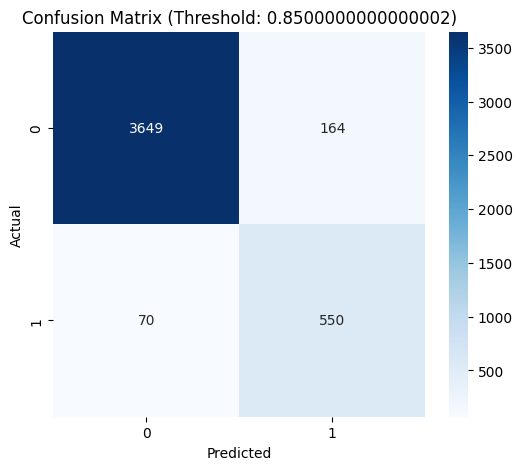

In [622]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get Probabilities (Confidence scores)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 2. Find Best Threshold for F1-Score
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    preds = (y_probs >= thresh).astype(int)
    current_f1 = f1_score(y_test, preds)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = thresh

print(f"\n🏆 Best Threshold Found: {best_thresh}")
print(f"   Max F1-Score: {best_f1:.4f}")

# 3. Final Predictions using Best Threshold
y_pred_final = (y_probs >= best_thresh).astype(int)

# 4. Visualizing Results
print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred_final))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Threshold: {best_thresh})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Feature Importance Analysis
- XGBoost has a built-in way to rank your features. It counts how many times each feature (like Pressur or Tool wear) was used to make a key decision in the "trees."
- Longer Bar = More Important.
- The feature at the very top is the #1 Predictor. This is the sensor your maintenance team should watch most closely.

- If Pressure or Tool wear [min] is at the top, it means mechanical stress is the main killer.
- If HDF (Heat Dissipation Failure) is high, it means temperature is the issue.

C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_17512\3463800749.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')


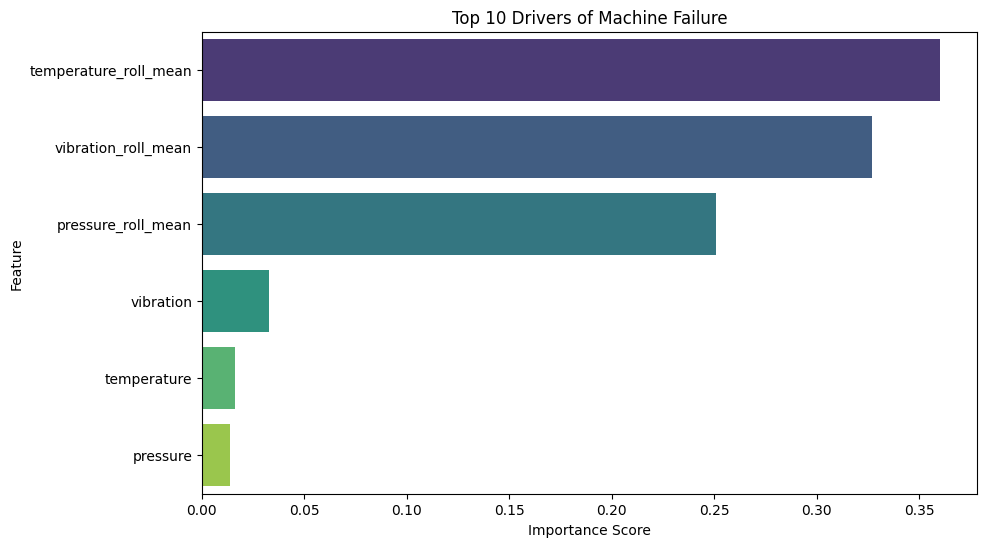

In [623]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the feature importance from your tuned XGBoost model
# (Assumes your model variable is named 'best_model' or 'xgb_model')
importances = xgb_model.feature_importances_

# 2. Map them to the column names
feature_names = list(X_train.columns)
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 3. Sort by importance so the winners are at the top
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# 4. Plot the Top 10 Features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')
plt.title('Top 10 Drivers of Machine Failure')
plt.xlabel('Importance Score')
plt.show()

## Interpretability & Trust (XAI)



### Generate SHAP Explanations


In [624]:
import shap
# 1. Initialize the Javascript visualization library (needed for plots)
shap.initjs()

# 2. Create the Explainer
# We pass the trained model to it
explainer = shap.TreeExplainer(xgb_model, X_train)

# 3. Calculate SHAP values for the Test Set
# (This might take a minute if your dataset is huge)
shap_values = explainer.shap_values(X_test)

print("--- SHAP Values Calculated ---")

--- SHAP Values Calculated ---


Analyzing Machine Index: 16347


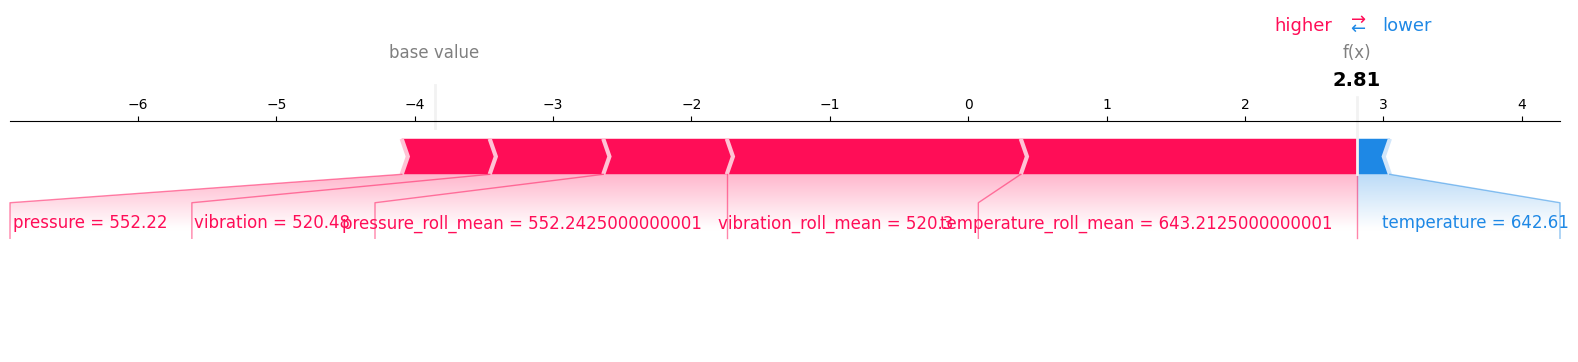

In [625]:
import numpy as np

# Normalize SHAP outputs and make force-plot robust for binary/multi-class outputs
# (Relies on explainer and shap_values computed in earlier cells; recompute if missing.)


if 'explainer' not in globals():
    explainer = shap.TreeExplainer(xgb_model, X_train_smote)

if 'shap_values' not in globals():
    shap_values = explainer.shap_values(X_test)

# Select correct SHAP array for plotting (handle list vs ndarray)
if isinstance(shap_values, list):
    shap_arr = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_arr = shap_values

# Normalize expected value similarly
exp_val = explainer.expected_value
if isinstance(exp_val, (list, np.ndarray)):
    exp_val = exp_val[1] if len(exp_val) > 1 else exp_val[0]

# Choose a failure index (fallback to first index if no failures in y_test)
if (y_test == 1).any():
    failure_index = y_test[y_test == 1].index[0]
else:
    failure_index = y_test.index[0]

loc_index = X_test.index.get_loc(failure_index)
print(f"Analyzing Machine Index: {failure_index}")

# Plot force plot for the chosen sample (matplotlib renderer)
shap.force_plot(exp_val, shap_arr[loc_index, :], X_test.iloc[loc_index, :], matplotlib=True)

### Visualize "Global" Importance (Summary Plot)

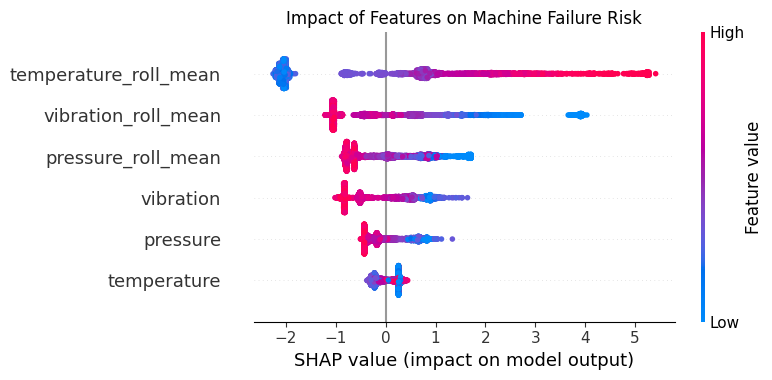

In [626]:
# Plot the Global Summary
plt.title("Impact of Features on Machine Failure Risk")
shap.summary_plot(shap_values, X_test)

### Visualize "Local" Importance (Force Plot)

Analyzing Machine Index: 16347


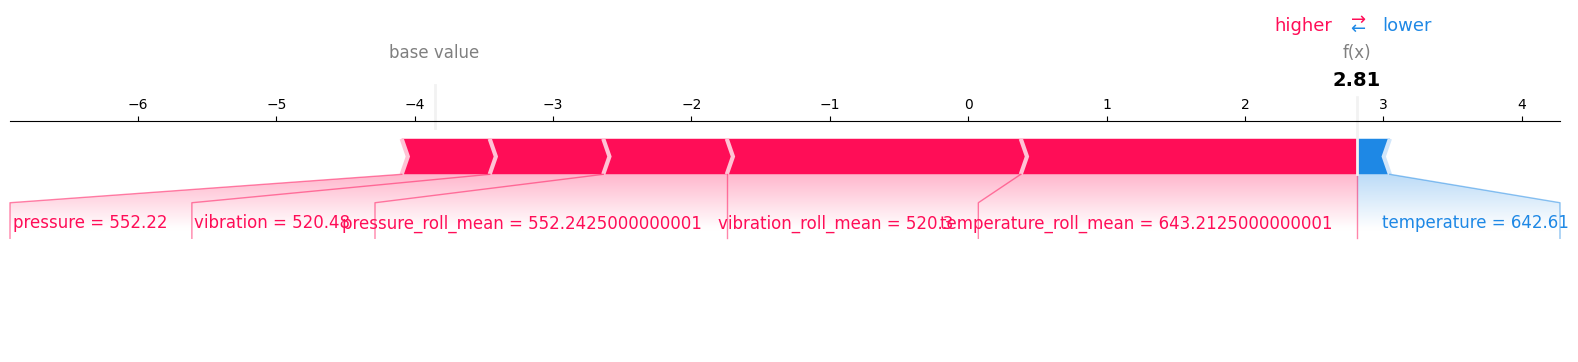

In [627]:
# Find the index of a machine that actually failed (Label = 1)
# We look for the first instance in y_test where failure occurred
failure_index = y_test[y_test == 1].index[0]
# Get the location of this index in the X_test array
loc_index = X_test.index.get_loc(failure_index)

print(f"Analyzing Machine Index: {failure_index}")

# Plot the Force Plot for this specific machine
shap.force_plot(explainer.expected_value, shap_values[loc_index,:], X_test.iloc[loc_index,:], matplotlib=True)